<a href="https://colab.research.google.com/github/Kostia9/Data-Analysis-2025/blob/main/Lab3/Lab3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Convolutional Neural Networks

This dataset contains a total of 3846 images placed in folders, with each folder representing one of the top new wonders of the world. Below is the list of wonders with images extracted from Google Images:

*   Venezuela Angel Falls
*   Taj Mahal
*   Stonehenge
*   Statue of Liberty
*   Chichen Itza
*   Christ the Redeemer
*   Pyramids of Giza
*   Eiffel Tower
*   Great Wall of China
*   Burj Khalifa
*   Roman Colosseum
*   Machu Picchu

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import kagglehub

path = kagglehub.dataset_download("balabaskar/wonders-of-the-world-image-classification")

print("Path to dataset files:", path)

100%|██████████| 432M/432M [00:20<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balabaskar/wonders-of-the-world-image-classification/versions/2


In [3]:
#path = '/root/.cache/kagglehub/datasets/balabaskar/wonders-of-the-world-image-classification/versions/2'
image_folder_path = path + "/Wonders of World/Wonders of World"
csv_path = path + "/wonders_of_world_images.csv"

print("Вміст папки із зображеннями (класи):")
!ls "{image_folder_path}"

import pandas as pd
df = pd.read_csv(csv_path)

print("\nПерші 5 рядків CSV-файлу:")
print(df.head())

Вміст папки із зображеннями (класи):
burj_khalifa	     great_wall_of_china  statue_of_liberty
chichen_itza	     machu_pichu	  stonehenge
christ_the_reedemer  pyramids_of_giza	  taj_mahal
eiffel_tower	     roman_colosseum	  venezuela_angel_falls

Перші 5 рядків CSV-файлу:
    folder_name        filename
0  burj_khalifa  0005487c0b.jpg
1  burj_khalifa  00d4a42317.jpg
2  burj_khalifa  01bbf1f63c.jpg
3  burj_khalifa  01f75e9545.jpg
4  burj_khalifa  020f2c752c.jpg


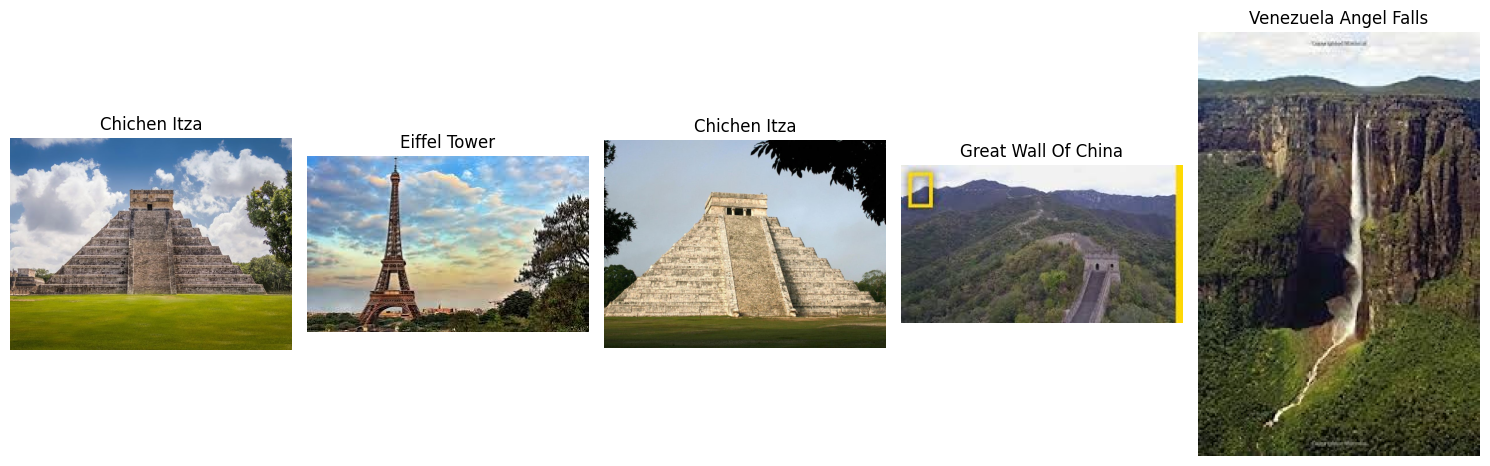

In [4]:
num_images_to_show = 5

random_images = df.sample(num_images_to_show)

plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(random_images.iterrows()):
    folder_name = row['folder_name']
    filename = row['filename']

    image_path = os.path.join(image_folder_path, folder_name, filename)

    plt.subplot(1, num_images_to_show, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title(folder_name.replace('_', ' ').title())
    plt.axis('off')

plt.tight_layout()
plt.show()

## Resolution distribution

Resolution Distribution:
Number of images: 3846
Min Width: 99, Max Width: 5000, Average Width: 616.57
Min Height: 116, Max Height: 4359, Average Height: 457.53


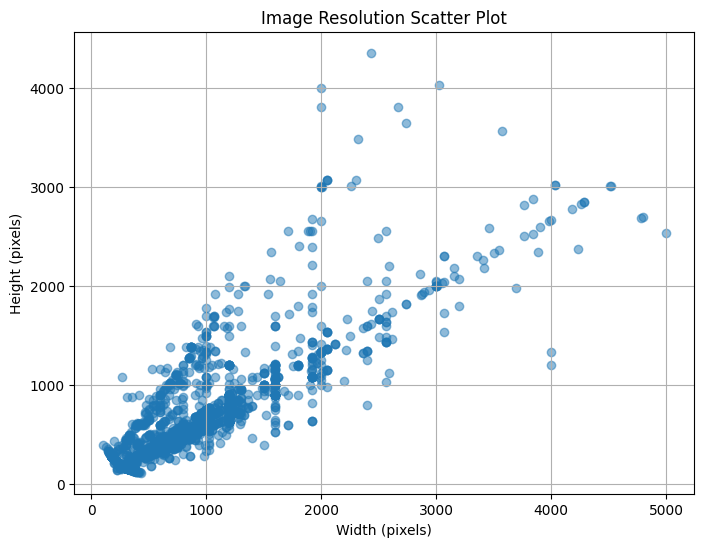

In [5]:
# Get image resolutions
resolutions = []
for index, row in df.iterrows():
    folder_name = row['folder_name']
    filename = row['filename']
    image_path = os.path.join(image_folder_path, folder_name, filename)
    try:
        with Image.open(image_path) as img:
            resolutions.append(img.size) # (width, height)
    except FileNotFoundError:
        print(f"Warning: Image not found at {image_path}")
        continue


# Analyze resolution distribution
widths = [res[0] for res in resolutions]
heights = [res[1] for res in resolutions]

print("Resolution Distribution:")
print(f"Number of images: {len(resolutions)}")
print(f"Min Width: {min(widths)}, Max Width: {max(widths)}, Average Width: {sum(widths)/len(widths):.2f}")
print(f"Min Height: {min(heights)}, Max Height: {max(heights)}, Average Height: {sum(heights)/len(heights):.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(widths, heights, alpha=0.5)
plt.title('Image Resolution Scatter Plot')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True)
plt.show()

## Class distribution


In [6]:
class_distribution = df['folder_name'].value_counts()
print(class_distribution)

folder_name
roman_colosseum          394
machu_pichu              393
great_wall_of_china      392
eiffel_tower             391
burj_khalifa             390
pyramids_of_giza         372
chichen_itza             340
christ_the_reedemer      323
venezuela_angel_falls    251
statue_of_liberty        238
stonehenge               204
taj_mahal                158
Name: count, dtype: int64


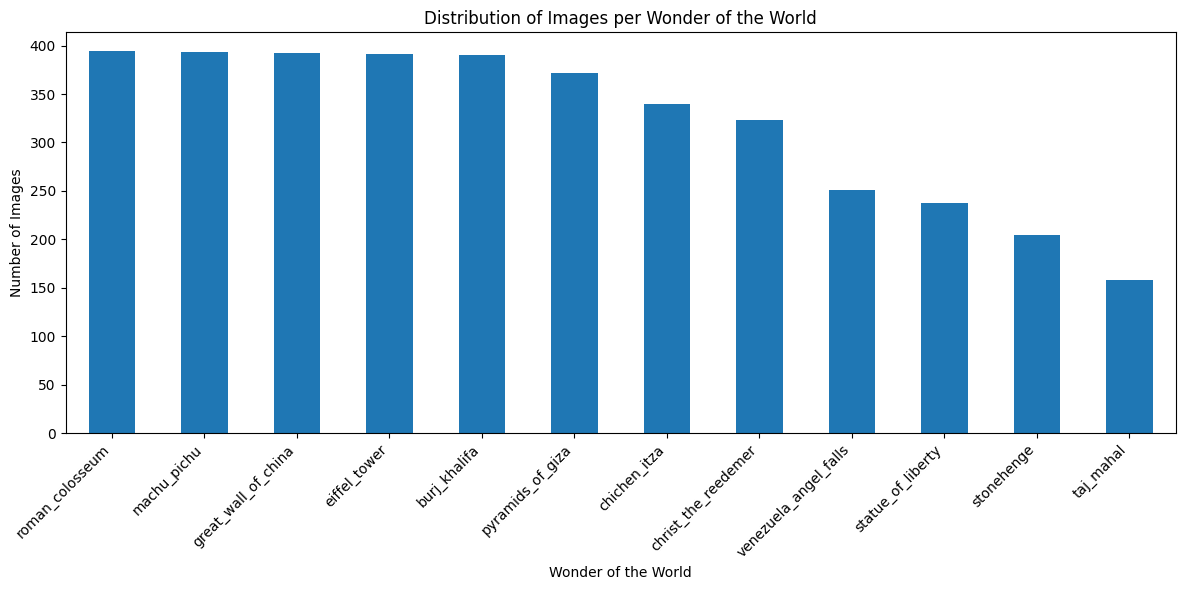

In [7]:
plt.figure(figsize=(12, 6))
class_distribution.plot(kind='bar')
plt.title('Distribution of Images per Wonder of the World')
plt.xlabel('Wonder of the World')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Define the model

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        def block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.feat = nn.Sequential(
            block(3, 32),   # /2
            block(32, 64),  # /4
            block(64, 128)  # /8
        )
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.fc  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.feat(x)
        x = self.gap(x).flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [9]:
img_size = 224
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

In [10]:
# Create dataset objects
full_dataset = ImageFolder(image_folder_path, transform=train_transforms) # Use train_transforms for the full dataset initially

total_size = len(full_dataset)
train_size = int(0.7 * total_size) # 70% for training
val_size = int(0.15 * total_size) # 15% for validation
test_size = total_size - train_size - val_size # Remaining 15% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply validation and test transforms to the respective datasets
val_dataset.dataset.transform = val_transforms
test_dataset.dataset.transform = val_transforms

batch_size = 256

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


num_classes = len(full_dataset.classes)
# Print information
print(f"Number of classes: {num_classes}")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Number of classes: 12
Training dataset size: 2692
Validation dataset size: 576
Test dataset size: 578


In [11]:
from tqdm import tqdm

def train_epoch(model, dataloader, criterion, device, optimizer):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in tqdm(dataloader, desc="Epoch Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        current_loss_item = loss.item()
        running_loss += current_loss_item * images.size(0)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    average_loss = running_loss / len(dataloader.dataset)
    accuracy = correct_predictions / total_predictions

    return average_loss, accuracy

def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Epoch Val", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            current_loss_item = loss.item()
            running_loss += current_loss_item * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    average_loss = running_loss / len(dataloader.dataset)
    accuracy = correct_predictions / total_predictions

    return average_loss, accuracy

## Train the model


In [12]:
device = 'cuda'
model = SimpleCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=0.003)

num_epochs = 50

patience = 5
patience_left = patience
best_loss = float('inf')

best_val_accuracy = -1.0
best_model_state = None

print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, device, optimizer
    )

    val_loss, val_acc = val_epoch(
        model, val_loader, criterion, device
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        best_val_accuracy = val_acc
        best_model_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        print(f"  ↑ New best! Val Acc: {best_val_accuracy:.4f} — saving state.")
        patience_left = patience
    else:
        patience_left -= 1

    if patience_left == 0:
        print("Early stop."); break

print("\nTraining finished.")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model state.")

Starting training...


Epoch [1/50] | Train Loss: 2.1844 | Train Acc: 0.2663 | Val Loss: 2.1551 | Val Acc: 0.2847
  ↑ New best! Val Acc: 0.2847 — saving state.


Epoch [2/50] | Train Loss: 1.9267 | Train Acc: 0.3774 | Val Loss: 1.9353 | Val Acc: 0.3941
  ↑ New best! Val Acc: 0.3941 — saving state.


Epoch [3/50] | Train Loss: 1.8003 | Train Acc: 0.4131 | Val Loss: 1.6953 | Val Acc: 0.4861
  ↑ New best! Val Acc: 0.4861 — saving state.


Epoch [4/50] | Train Loss: 1.7077 | Train Acc: 0.4614 | Val Loss: 1.7458 | Val Acc: 0.4149


Epoch [5/50] | Train Loss: 1.6295 | Train Acc: 0.4788 | Val Loss: 1.6137 | Val Acc: 0.4774
  ↑ New best! Val Acc: 0.4774 — saving state.


Epoch [6/50] | Train Loss: 1.5297 | Train Acc: 0.5171 | Val Loss: 1.6215 | Val Acc: 0.4653


Epoch [7/50] | Train Loss: 1.5038 | Train Acc: 0.5193 | Val Loss: 1.5367 | Val Acc: 0.4375
  ↑ New best! Val Acc: 0.4375 — saving state.


Epoch [8/50] | Train Loss: 1.4514 | Train Acc: 0.5371 | Val Loss: 1.4505 | Val Acc: 0.5469
  ↑ New best! Val Acc: 0.5469 — saving state.


Epoch [9/50] | Train Loss: 1.4110 | Train Acc: 0.5516 | Val Loss: 1.3371 | Val Acc: 0.5747
  ↑ New best! Val Acc: 0.5747 — saving state.


Epoch [10/50] | Train Loss: 1.3608 | Train Acc: 0.5762 | Val Loss: 1.4998 | Val Acc: 0.5399


Epoch [11/50] | Train Loss: 1.3106 | Train Acc: 0.5958 | Val Loss: 1.3182 | Val Acc: 0.5677
  ↑ New best! Val Acc: 0.5677 — saving state.


Epoch [12/50] | Train Loss: 1.2782 | Train Acc: 0.6007 | Val Loss: 1.2811 | Val Acc: 0.5990
  ↑ New best! Val Acc: 0.5990 — saving state.


Epoch [13/50] | Train Loss: 1.2818 | Train Acc: 0.5925 | Val Loss: 1.3852 | Val Acc: 0.5608


Epoch [14/50] | Train Loss: 1.2281 | Train Acc: 0.6178 | Val Loss: 1.1679 | Val Acc: 0.6181
  ↑ New best! Val Acc: 0.6181 — saving state.


Epoch [15/50] | Train Loss: 1.1889 | Train Acc: 0.6274 | Val Loss: 1.1531 | Val Acc: 0.5920
  ↑ New best! Val Acc: 0.5920 — saving state.


Epoch [16/50] | Train Loss: 1.1494 | Train Acc: 0.6315 | Val Loss: 1.0985 | Val Acc: 0.6528
  ↑ New best! Val Acc: 0.6528 — saving state.


Epoch [17/50] | Train Loss: 1.1327 | Train Acc: 0.6497 | Val Loss: 1.1270 | Val Acc: 0.6424


Epoch [18/50] | Train Loss: 1.1414 | Train Acc: 0.6378 | Val Loss: 1.1236 | Val Acc: 0.6424


Epoch [19/50] | Train Loss: 1.1240 | Train Acc: 0.6501 | Val Loss: 1.0639 | Val Acc: 0.6719
  ↑ New best! Val Acc: 0.6719 — saving state.


Epoch [20/50] | Train Loss: 1.0693 | Train Acc: 0.6568 | Val Loss: 1.1497 | Val Acc: 0.6302


Epoch [21/50] | Train Loss: 1.0772 | Train Acc: 0.6516 | Val Loss: 1.0109 | Val Acc: 0.6927
  ↑ New best! Val Acc: 0.6927 — saving state.


Epoch [22/50] | Train Loss: 1.0540 | Train Acc: 0.6753 | Val Loss: 1.2930 | Val Acc: 0.6007


Epoch [23/50] | Train Loss: 1.0470 | Train Acc: 0.6612 | Val Loss: 1.0072 | Val Acc: 0.6684
  ↑ New best! Val Acc: 0.6684 — saving state.


Epoch [24/50] | Train Loss: 0.9970 | Train Acc: 0.6872 | Val Loss: 1.0236 | Val Acc: 0.6910


Epoch [25/50] | Train Loss: 0.9724 | Train Acc: 0.7021 | Val Loss: 0.9281 | Val Acc: 0.7465
  ↑ New best! Val Acc: 0.7465 — saving state.


Epoch [26/50] | Train Loss: 0.9774 | Train Acc: 0.6976 | Val Loss: 0.9150 | Val Acc: 0.7135
  ↑ New best! Val Acc: 0.7135 — saving state.


Epoch [27/50] | Train Loss: 0.9412 | Train Acc: 0.7051 | Val Loss: 1.4153 | Val Acc: 0.5694


Epoch [28/50] | Train Loss: 0.9534 | Train Acc: 0.7125 | Val Loss: 1.1318 | Val Acc: 0.6458


Epoch [29/50] | Train Loss: 0.9325 | Train Acc: 0.7065 | Val Loss: 0.9303 | Val Acc: 0.7170


Epoch [30/50] | Train Loss: 0.8819 | Train Acc: 0.7244 | Val Loss: 1.0275 | Val Acc: 0.6615


Epoch [31/50] | Train Loss: 0.8865 | Train Acc: 0.7214 | Val Loss: 1.0167 | Val Acc: 0.6962
Early stop.

Training finished.
Loaded best model state.


# Evaluate the best model on the test set

In [13]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes))

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

Classification Report:
                       precision    recall  f1-score   support

         burj_khalifa       0.74      0.66      0.70        74
         chichen_itza       0.68      0.83      0.75        47
  christ_the_reedemer       0.52      0.47      0.49        51
         eiffel_tower       0.63      0.58      0.61        65
  great_wall_of_china       0.44      0.85      0.58        53
          machu_pichu       0.90      0.62      0.73        60
     pyramids_of_giza       0.86      0.86      0.86        51
      roman_colosseum       0.94      0.89      0.91        54
    statue_of_liberty       0.71      0.63      0.67        27
           stonehenge       0.83      0.58      0.68        33
            taj_mahal       0.77      0.62      0.69        16
venezuela_angel_falls       0.75      0.70      0.73        47

             accuracy                           0.70       578
            macro avg       0.73      0.69      0.70       578
         weighted avg       0.

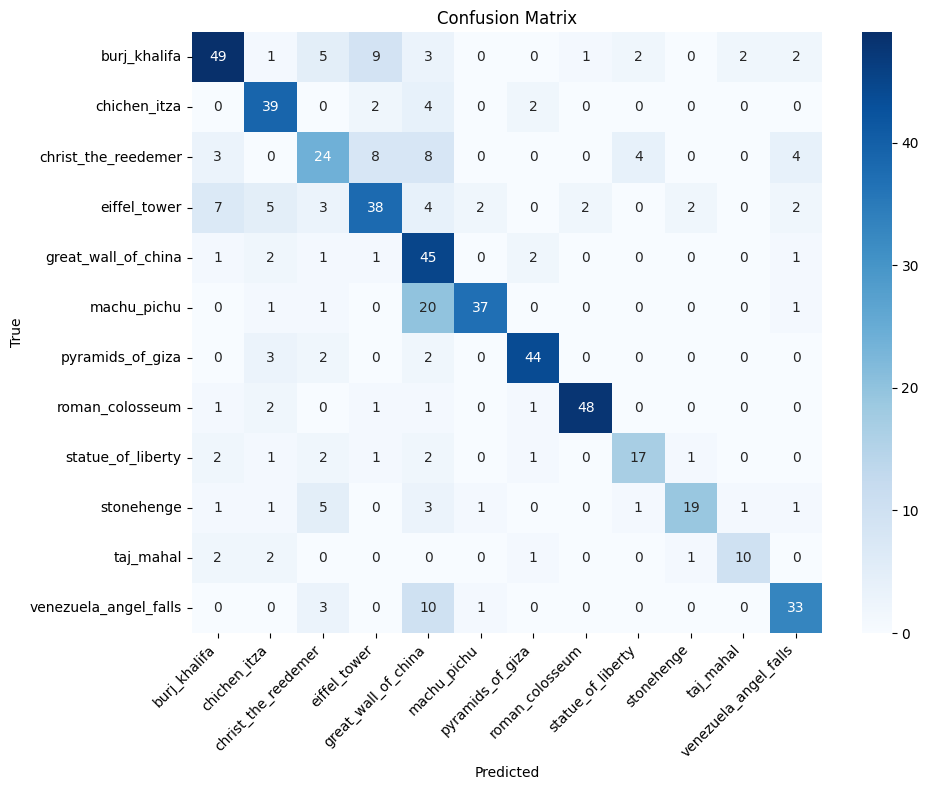

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Fine-tune a pretrained EfficientNetB3 model on the same dataset.

In [15]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

weights = EfficientNet_B3_Weights.DEFAULT
model_2 = efficientnet_b3(weights=weights)

# Modify the final layer to match the number of classes in your dataset
num_features = model_2.classifier[1].in_features
model_2.classifier[1] = nn.Linear(num_features, num_classes)

# Move the model to the appropriate device
model_2 = model_2.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 152MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()

# Define different learning rates for different parts of the model
lr_features = 1e-5  # Lower learning rate for pretrained layers
lr_classifier = 1e-3 # Higher learning rate for the new classifier layer

optimizer_2 = optim.AdamW([
    {'params': model_2.features.parameters(), 'lr': lr_features},
    {'params': model_2.classifier.parameters(), 'lr': lr_classifier}
])

print("Loss function defined:", criterion)
print("Optimizer defined with different learning rates.")

Loss function defined: CrossEntropyLoss()
Optimizer defined with different learning rates.


In [17]:
# Create DataLoaders
batch_size_efficientnet = 32

train_loader_efficientnet = DataLoader(train_dataset, batch_size=batch_size_efficientnet, shuffle=True)
val_loader_efficientnet = DataLoader(val_dataset, batch_size=batch_size_efficientnet, shuffle=False)
test_loader_efficientnet = DataLoader(test_dataset, batch_size=batch_size_efficientnet, shuffle=False)

print(f"Training DataLoader created with batch size {batch_size_efficientnet}")
print(f"Validation DataLoader created with batch size {batch_size_efficientnet}")
print(f"Test DataLoader created with batch size {batch_size_efficientnet}")

Training DataLoader created with batch size 32
Validation DataLoader created with batch size 32
Test DataLoader created with batch size 32


In [18]:
num_epochs = 20

patience = 5
patience_left = patience
best_loss = float('inf')

best_val_accuracy = -1.0
best_model_2_state = None

print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(
        model_2, train_loader_efficientnet, criterion, device, optimizer_2
    )

    val_loss, val_acc = val_epoch(
        model_2, val_loader_efficientnet, criterion, device
    )

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"| Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
        f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
    )

    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        best_val_accuracy = val_acc
        best_model_2_state = {k: v.cpu().clone() for k,v in model_2.state_dict().items()}
        print(f"  ↑ New best! Val Acc: {best_val_accuracy:.4f} — saving state.")
        patience_left = patience
    else:
        patience_left -= 1

    if patience_left == 0:
            print("Early stop."); break

print("\nTraining finished.")

if best_model_2_state is not None:
    model_2.load_state_dict(best_model_2_state)
    print("Loaded best model state.")

Starting training...


Epoch [1/20] | Train Loss: 1.4211 | Train Acc: 0.7010 | Val Loss: 2.5227 | Val Acc: 0.9028
  ↑ New best! Val Acc: 0.9028 — saving state.


Epoch [2/20] | Train Loss: 0.4705 | Train Acc: 0.9242 | Val Loss: 0.6418 | Val Acc: 0.9444
  ↑ New best! Val Acc: 0.9444 — saving state.


Epoch [3/20] | Train Loss: 0.2689 | Train Acc: 0.9513 | Val Loss: 1.6768 | Val Acc: 0.9549


Epoch [4/20] | Train Loss: 0.1900 | Train Acc: 0.9632 | Val Loss: 2.9207 | Val Acc: 0.9601


Epoch [5/20] | Train Loss: 0.1309 | Train Acc: 0.9796 | Val Loss: 6.4205 | Val Acc: 0.9653


Epoch [6/20] | Train Loss: 0.1120 | Train Acc: 0.9785 | Val Loss: 0.2179 | Val Acc: 0.9705
  ↑ New best! Val Acc: 0.9705 — saving state.


Epoch [7/20] | Train Loss: 0.0790 | Train Acc: 0.9851 | Val Loss: 1.3414 | Val Acc: 0.9792


Epoch [8/20] | Train Loss: 0.0656 | Train Acc: 0.9874 | Val Loss: 0.4117 | Val Acc: 0.9774


Epoch [9/20] | Train Loss: 0.0569 | Train Acc: 0.9889 | Val Loss: 1.5141 | Val Acc: 0.9792


Epoch [10/20] | Train Loss: 0.0544 | Train Acc: 0.9877 | Val Loss: 0.0840 | Val Acc: 0.9792
  ↑ New best! Val Acc: 0.9792 — saving state.


Epoch [11/20] | Train Loss: 0.0382 | Train Acc: 0.9944 | Val Loss: 0.4264 | Val Acc: 0.9809


Epoch [12/20] | Train Loss: 0.0361 | Train Acc: 0.9937 | Val Loss: 3.4355 | Val Acc: 0.9792


Epoch [13/20] | Train Loss: 0.0305 | Train Acc: 0.9952 | Val Loss: 0.1615 | Val Acc: 0.9757


Epoch [14/20] | Train Loss: 0.0235 | Train Acc: 0.9955 | Val Loss: 5.4251 | Val Acc: 0.9826


Epoch [15/20] | Train Loss: 0.0199 | Train Acc: 0.9970 | Val Loss: 0.8132 | Val Acc: 0.9809
Early stop.

Training finished.
Loaded best model state.


# Evaluate the best model on the test set

In [19]:
model_2.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.dataset.classes))

# Generate confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_mat)

Classification Report:
                       precision    recall  f1-score   support

         burj_khalifa       0.99      0.99      0.99        74
         chichen_itza       0.96      1.00      0.98        47
  christ_the_reedemer       0.98      1.00      0.99        51
         eiffel_tower       1.00      0.95      0.98        65
  great_wall_of_china       0.95      0.98      0.96        53
          machu_pichu       1.00      0.97      0.98        60
     pyramids_of_giza       1.00      0.98      0.99        51
      roman_colosseum       1.00      0.98      0.99        54
    statue_of_liberty       0.96      1.00      0.98        27
           stonehenge       1.00      1.00      1.00        33
            taj_mahal       0.94      0.94      0.94        16
venezuela_angel_falls       0.96      0.98      0.97        47

             accuracy                           0.98       578
            macro avg       0.98      0.98      0.98       578
         weighted avg       0.

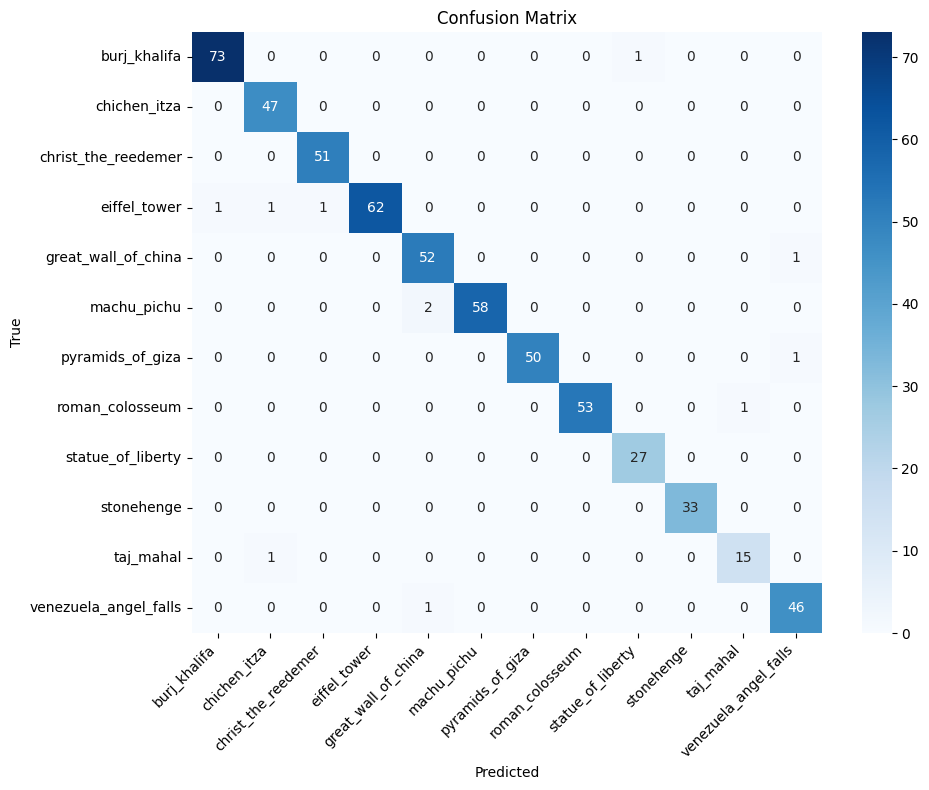

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()